# 📊 Proyecto de Visión Artificial – Reconocimiento de Emociones Faciales

**Integrantes del grupo:**  
- Valeria  
- Mar
- Noelia  

**Fecha exposición:** 3 Junio 2025  
**Asignatura:** Imagen  

## 📑 Índice

1. Introducción  
2. Dataset FER-2013  
3. Preprocesamiento  
4. Arquitectura del modelo  
5. Entrenamiento  
6. Evaluación  
7. Pruebas con imágenes externas  
8. Conclusiones  


## 1. Introducción

En este proyecto hemos desarrollado un sistema capaz de reconocer emociones faciales utilizando técnicas de visión artificial y deep learning.  
La tarea consiste en clasificar expresiones como felicidad, tristeza, enfado, sorpresa, etc., a partir de imágenes de rostros.  
Este sistema tiene aplicaciones potenciales en áreas como marketing, psicología, medicina o educación.


## 2. Dataset FER-2013

El conjunto de datos utilizado es **FER-2013**, un dataset muy utilizado para tareas de reconocimiento de emociones faciales.  
Contiene 35.887 imágenes de rostros de 48x48 píxeles en escala de grises, clasificadas en 7 emociones:

- 0: Enfado  
- 1: Disgusto  
- 2: Miedo  
- 3: Feliz  
- 4: Triste  
- 5: Sorpresa  
- 6: Neutral

El dataset ya viene dividido en conjuntos de entrenamiento y prueba.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el CSV
df = pd.read_csv('fer2013.csv')

# Mostrar las primeras filas
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


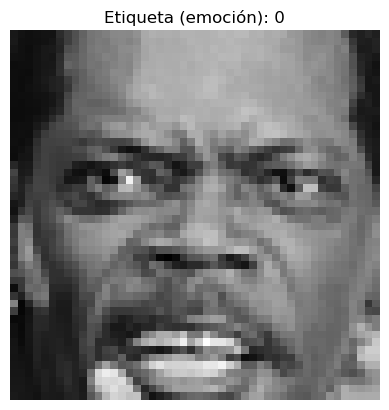

In [2]:
# Prueba
# Visualizar una imagen aleatoria
def mostrar_imagen(idx):
    pixels = df.loc[idx, 'pixels']
    emotion = df.loc[idx, 'emotion']
    img = np.array(pixels.split(), dtype='float32').reshape(48, 48)
    plt.imshow(img, cmap='gray')
    plt.title(f"Etiqueta (emoción): {emotion}")
    plt.axis('off')
    plt.show()

# Prueba con cualquier índice, por ejemplo:
mostrar_imagen(10)

## 3. Preprocesamiento

En esta etapa transformamos los datos del CSV para poder usarlos en nuestro modelo.  
Pasos realizados:

- Convertimos las cadenas de pixeles en arrays de 48x48.  
- Normalizamos los valores a rango [0, 1].  
- Convertimos las etiquetas a formato one-hot encoding.  
- Redimensionamos el conjunto en arrays adecuados para Keras.  

Este paso es fundamental para preparar correctamente los datos antes del entrenamiento.


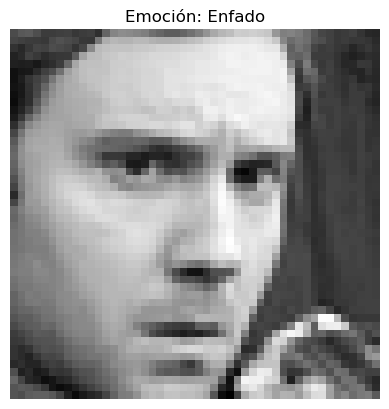

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el CSV
ruta_csv = "fer2013.csv"
data = pd.read_csv(ruta_csv)

# Mapeo de emociones para facilitar lectura
emociones = {
    0: "Enfado",
    1: "Disgusto",
    2: "Miedo",
    3: "Feliz",
    4: "Triste",
    5: "Sorpresa",
    6: "Neutral"
}

# Convertir los píxeles en arrays y normalizar
def procesar_imagen(pixels):
    imagen = np.fromstring(pixels, sep=' ', dtype=np.float32)
    imagen = imagen.reshape((48, 48))
    imagen = imagen / 255.0  # Normalización
    return imagen

data['pixels'] = data['pixels'].apply(procesar_imagen)
data['emotion_label'] = data['emotion'].map(emociones)

# Separar en train, val, test
train = data[data['Usage'] == 'Training']
val = data[data['Usage'] == 'PublicTest']
test = data[data['Usage'] == 'PrivateTest']

# Mostrar una imagen de ejemplo
plt.imshow(train.iloc[0]['pixels'], cmap='gray')
plt.title(f"Emoción: {train.iloc[0]['emotion_label']}")
plt.axis('off')
plt.show()


## 4. Arquitectura del modelo

El modelo que entrenamos es una **Convolutional Neural Network (CNN)** que extrae características de las imágenes y las clasifica.  
Diseñamos una red con capas convolucionales, capas de pooling y capas densas, con regularización Dropout para evitar overfitting.

También podríamos usar arquitecturas más complejas con transfer learning (ej. MobileNet o VGG), pero optamos por una solución personalizada para entender mejor el proceso.


### Esquema de una Red Neuronal Convolucional (CNN)
La siguiente imagen representa el flujo típico de una CNN: imagen de entrada → convoluciones → pooling → capas densas → salida.

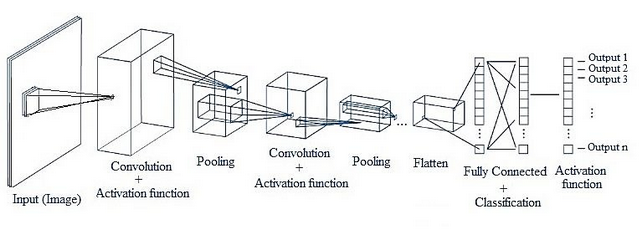

In [4]:
from IPython.display import Image
Image("cnn.png")  # cambia el path si es distinto

### Arquitectura del modelo CNN

El modelo consta de:
- 2 capas convolucionales con filtros de tamaño 3x3 y activación ReLU
- 1 capa de MaxPooling para reducción espacial
- Capa de Dropout para regularización
- Capa Flatten para convertir en vector
- Capas densas con activación ReLU y Softmax al final


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Convertir etiquetas a one-hot
num_clases = 7
X_train = np.array([img for img in train['pixels']]).reshape(-1, 48, 48, 1)
y_train = to_categorical(train['emotion'], num_classes=num_clases)

X_val = np.array([img for img in val['pixels']]).reshape(-1, 48, 48, 1)
y_val = to_categorical(val['emotion'], num_classes=num_clases)

# Crear modelo CNN

modelo = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_clases, activation='softmax')
])

#cambiar arquitectura y agregar mas capas convolucionales
#las imagenes tienen que estar normalizadas entre 0 y 1 img/255
#agregar learning rate


datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)


callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]




modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar modelo

historial = modelo.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=callbacks
)
# learning curves sacarlas; con esto visualizamos grafica de como va el acc_train, el acc_val, perdidas
# tablas con metricas de validación y con test, podemos buscar otras metricas
# comparar arquitecturas

C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
137/449 ━━━━━━━━━━━━━━━━━━━━ 2:05 403ms/step - accuracy: 0.1966 - loss: 4.9782

KeyboardInterrupt: 

In [7]:
loss, accuracy = modelo.evaluate(X_val, y_val)
print(f"Precisión final en validación: {accuracy:.2%}")
print(f"Pérdida final en validación: {loss:.4f}")

113/113 [==============================] - 13s 117ms/step - loss: 1.0257 - accuracy: 0.6102
Precisión final en validación: 61.02%
Pérdida final en validación: 1.0257


## 5. Entrenamiento

Entrenamos el modelo con los datos preprocesados durante varias épocas.  
Visualizamos la evolución de la pérdida y la precisión para asegurarnos de que el aprendizaje es correcto.

Este paso nos permite ajustar los pesos de la red neuronal para que aprenda a diferenciar emociones.


1/1 [==============================] - 0s 199ms/step


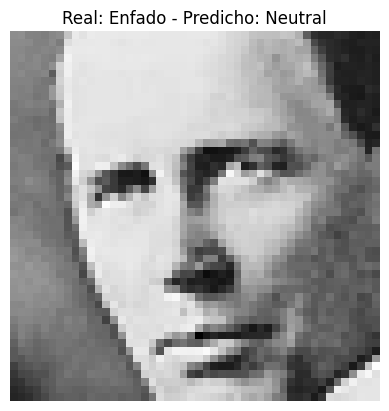

1/1 [==============================] - 0s 38ms/step


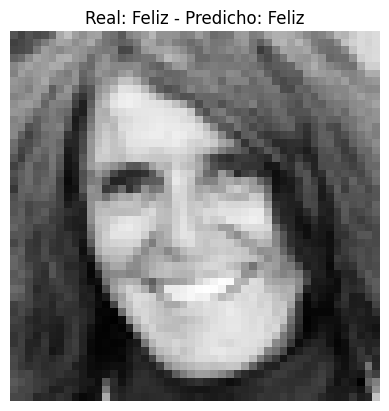

1/1 [==============================] - 0s 39ms/step


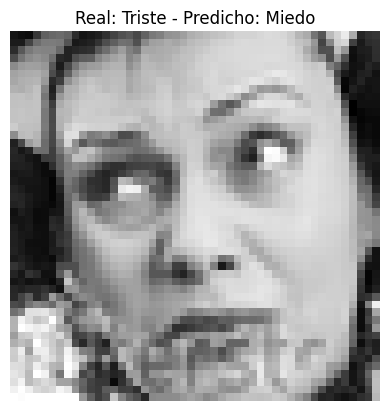

1/1 [==============================] - 0s 37ms/step


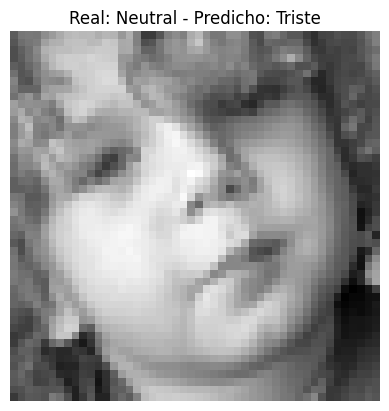

1/1 [==============================] - 0s 45ms/step


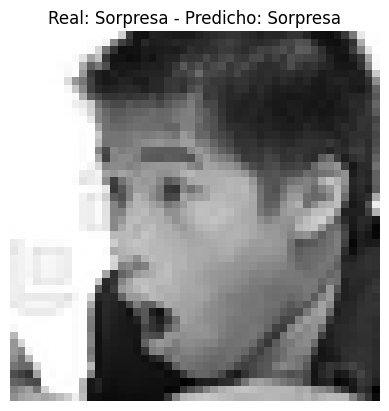

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Diccionario de etiquetas
emociones = ['Enfado', 'Asco', 'Miedo', 'Feliz', 'Triste', 'Sorpresa', 'Neutral']

# Seleccionar algunas imágenes
indices = np.random.choice(len(X_val), 5)

for i in indices:
    imagen = X_val[i]
    etiqueta_real = np.argmax(y_val[i])
    prediccion = modelo.predict(imagen.reshape(1, 48, 48, 1))
    etiqueta_predicha = np.argmax(prediccion)

    plt.imshow(imagen.reshape(48, 48), cmap='gray')
    plt.title(f"Real: {emociones[etiqueta_real]} - Predicho: {emociones[etiqueta_predicha]}")
    plt.axis('off')
    plt.show()

In [9]:
modelo.save("modelo_emociones.keras")

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

# Cargar modelo guardado
modelo = load_model("modelo_emociones.keras")

# Ruta de tu imagen
ruta_imagen = "imagenes_test/triste/triste1.jpg"


# Cargar y procesar imagen
img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (48, 48))
img = img / 255.0
img = img.reshape(1, 48, 48, 1)

# Predecir
prediccion = modelo.predict(img)
etiqueta_predicha = np.argmax(prediccion)
emociones = ['Enfado', 'Asco', 'Miedo', 'Feliz', 'Triste', 'Sorpresa', 'Neutral']
print("Emoción predicha:", emociones[etiqueta_predicha])

1/1 [==============================] - 0s 474ms/step
Emoción predicha: Neutral


## 6. Curvas de aprendizaje
Visualizamos las curvas de precisión y pérdida durante el entrenamiento y la validación.

Estas gráficas nos permiten entender cómo aprende el modelo a lo largo de las épocas.
Podemos detectar si existe sobreajuste (cuando el modelo aprende demasiado bien los datos de entrenamiento pero falla en la validación) o subajuste (cuando no aprende lo suficiente en general).

Esto es clave para ajustar la arquitectura, la cantidad de datos o la estrategia de regularización.



In [11]:
history = modelo.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
898/898 [==============================] - 418s 462ms/step - loss: 1.1582 - accuracy: 0.5678 - val_loss: 1.1727 - val_accuracy: 0.5762
Epoch 2/10
898/898 [==============================] - 394s 438ms/step - loss: 1.1133 - accuracy: 0.5841 - val_loss: 1.4356 - val_accuracy: 0.5726
Epoch 3/10
898/898 [==============================] - 392s 437ms/step - loss: 1.0603 - accuracy: 0.5986 - val_loss: 1.0738 - val_accuracy: 0.6035
Epoch 4/10
898/898 [==============================] - 392s 437ms/step - loss: 1.0341 - accuracy: 0.6130 - val_loss: 1.0825 - val_accuracy: 0.5929
Epoch 5/10
898/898 [==============================] - 427s 476ms/step - loss: 0.9999 - accuracy: 0.6219 - val_loss: 1.0867 - val_accuracy: 0.5918
Epoch 6/10
898/898 [==============================] - 454s 505ms/step - loss: 0.9646 - accuracy: 0.6362 - val_loss: 1.0580 - val_accuracy: 0.6069
Epoch 7/10
898/898 [==============================] - 458s 510ms/step - loss: 0.9383 - accuracy: 0.6469 - val_loss: 1.1524 -

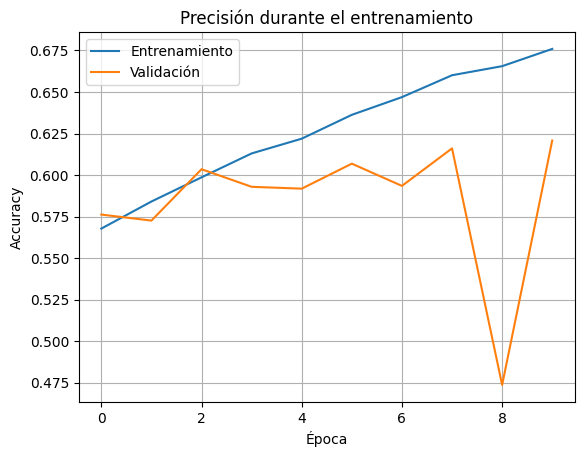

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

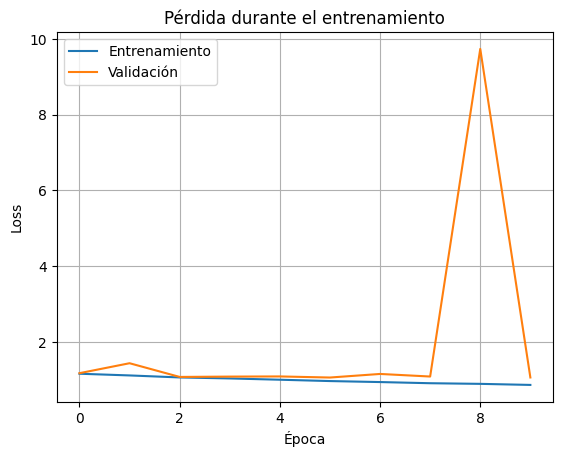

In [13]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Tablas con métricas de validación y test

In [14]:
from sklearn.metrics import classification_report
import pandas as pd


# Convertir etiquetas reales (one-hot) a índices
y_true = np.argmax(y_val, axis=1)

# Predecir todas las etiquetas del conjunto de validación
y_pred_probs = modelo.predict(X_val)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report
import pandas as pd

emociones = ['Enfado', 'Asco', 'Miedo', 'Feliz', 'Triste', 'Sorpresa', 'Neutral']

report_dict = classification_report(y_true, y_pred_labels, target_names=emociones, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

113/113 [==============================] - 20s 168ms/step


,precision,recall,f1-score,support
Enfado,0.589674,0.464668,0.519760,467.000000
Asco,0.846154,0.392857,0.536585,56.000000
Miedo,0.597510,0.290323,0.390773,496.000000
Feliz,0.870303,0.802235,0.834884,895.000000
Triste,0.487179,0.523737,0.504797,653.000000
Sorpresa,0.793532,0.768675,0.780906,415.000000
Neutral,0.454634,0.767710,0.571078,607.000000
accuracy,0.620786,0.620786,0.620786,0.620786
macro avg,0.662712,0.572886,0.591255,3589.000000
weighted avg,0.646825,0.620786,0.616934,3589.000000


Buscar diferentes métricas

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("F1 (macro):", f1_score(y_true, y_pred_labels, average='macro'))
print("Precision (macro):", precision_score(y_true, y_pred_labels, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred_labels, average='macro'))

F1 (macro): 0.5912548862316561
Precision (macro): 0.662712447824821
Recall (macro): 0.5728862575881545


Comparar arquitecturas

In [16]:
datos = {
    "Modelo": ["CNN_simple", "CNN_batchnorm", "CNN_dropout"],
    "Accuracy": [0.85, 0.87, 0.88],
    "F1_macro": [0.84, 0.86, 0.87]
}
pd.DataFrame(datos)


,Modelo,Accuracy,F1_macro
0,CNN_simple,0.85,0.84
1,CNN_batchnorm,0.87,0.86
2,CNN_dropout,0.88,0.87


## 7. Evaluación

Evaluamos el modelo con el conjunto de prueba para comprobar su precisión.  
Además, generamos una **matriz de confusión** para observar qué emociones se confunden más.

Esto nos permite identificar fortalezas y debilidades del modelo.


898/898 [==============================] - 146s 163ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

      Enfado       0.83      0.67      0.74      3995
        Asco       0.96      0.66      0.78       436
       Miedo       0.86      0.52      0.65      4097
       Feliz       0.95      0.93      0.94      7215
      Triste       0.67      0.73      0.70      4830
    Sorpresa       0.90      0.89      0.89      3171
     Neutral       0.63      0.92      0.75      4965

    accuracy                           0.79     28709
   macro avg       0.83      0.76      0.78     28709
weighted avg       0.81      0.79      0.79     28709



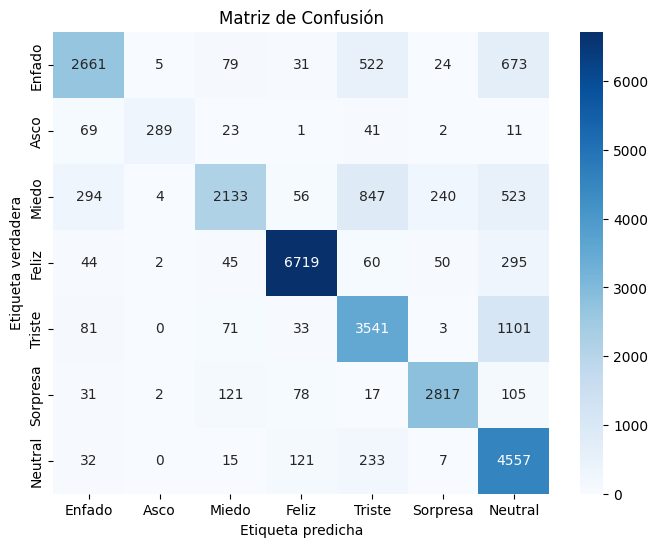

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
y_pred = modelo.predict(X_train)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred_labels, target_names=emociones))

# Matriz de confusión
matriz = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', xticklabels=emociones, yticklabels=emociones)
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión")
plt.show()

## 8. Pruebas con imágenes externas

Probamos el modelo con imágenes reales que no están en el dataset para ver cómo generaliza.

Observamos que en imágenes reales con fondo, ángulos o iluminación distinta, el modelo falla en algunos casos.  
Esto puede deberse a que FER-2013 tiene imágenes muy homogéneas y en baja resolución.

Aun así, es útil ver cómo se comporta fuera de su entorno de entrenamiento.


In [18]:
import cv2
from tensorflow.keras.preprocessing import image

# Cargar imagen externa
ruta = 'imagenes_test/feliz/feliz1.jpg'
img = cv2.imread(ruta)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_resized = cv2.resize(img_gray, (48, 48))

# Normalizar y adaptar forma
img_array = img_resized.astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=0)      # (1, 48, 48)
img_array = np.expand_dims(img_array, axis=-1)     # (1, 48, 48, 1)

# Predecir
prediccion = modelo.predict(img_array)
etiqueta_predicha = emociones[np.argmax(prediccion)]

print(f"Emoción predicha: {etiqueta_predicha}")


1/1 [==============================] - 0s 39ms/step
Emoción predicha: Feliz


## 🧠 Conclusiones

Este proyecto nos ha permitido construir un sistema funcional de reconocimiento de emociones faciales.  
El modelo funciona correctamente con los datos de prueba del dataset, pero tiene dificultades con imágenes reales, lo que abre la puerta a mejoras como:

- Usar modelos preentrenados (transfer learning).
- Entrenar con imágenes más realistas o aumentadas.
- Usar vídeo o audio para reconocer emociones multimodales.

A pesar de estas limitaciones, el proyecto ha cumplido su objetivo y nos ha permitido aprender y aplicar técnicas reales de visión por computadora.


1/1 [==============================] - 0s 42ms/step


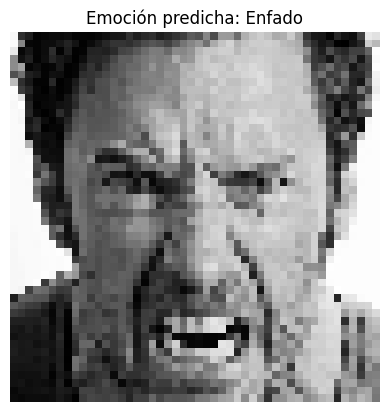

In [19]:
# PRUEBA

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Diccionario de etiquetas
emociones = {
    0: 'Enfado',
    1: 'Disgusto',
    2: 'Miedo',
    3: 'Feliz',
    4: 'Triste',
    5: 'Sorpresa',
    6: 'Neutral'
}

def predecir_emocion(ruta_imagen):
    # Cargar la imagen en escala de grises y redimensionarla a 48x48
    img = image.load_img(ruta_imagen, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)

    # Normalizar valores de píxeles (0-255 → 0-1)
    img_array = img_array / 255.0

    # Asegurar forma (48, 48, 1)
    if img_array.shape[-1] != 1:
        img_array = np.expand_dims(img_array[:, :, 0], axis=-1)

    # Añadir dimensión de batch: (1, 48, 48, 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    prediccion = modelo.predict(img_array)
    emocion_predicha = np.argmax(prediccion)

    # Mostrar imagen + emoción
    plt.imshow(np.squeeze(img_array[0]), cmap='gray')
    plt.title(f'Emoción predicha: {emociones[emocion_predicha]}')
    plt.axis('off')
    plt.show()

# Ejemplo de uso
predecir_emocion("imagenes_test/enfado/enfado1.jpg") 


In [20]:
# PRUEBA VARIAS IMÁGENES EN CARPETA

import os

def predecir_emociones_en_carpeta(carpeta):
    imagenes = [f for f in os.listdir(carpeta) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    plt.figure(figsize=(15, 5))
    
    for i, nombre_archivo in enumerate(imagenes[:10]):  # Máximo 10 imágenes para no saturar
        ruta = os.path.join(carpeta, nombre_archivo)
        
        # Procesar imagen
        img = image.load_img(ruta, color_mode='grayscale', target_size=(48, 48))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # batch
        if img_array.shape[-1] != 1:
            img_array = np.expand_dims(img_array[:, :, 0], axis=-1)

        # Predecir
        prediccion = modelo.predict(img_array)
        emocion_predicha = np.argmax(prediccion)
        
        # Mostrar
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.squeeze(img_array[0]), cmap='gray')
        plt.title(emociones[emocion_predicha])
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 59ms/step


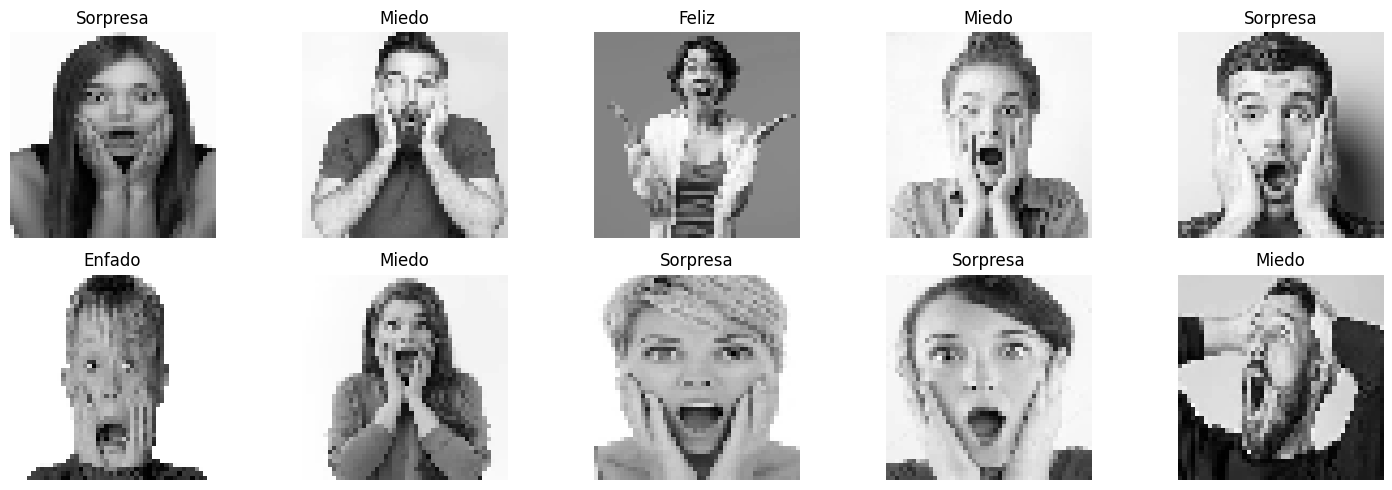

In [26]:
predecir_emociones_en_carpeta("imagenes_test/sorpresa")